# [모듈 1.1] Sentence-BERT (SBERT) Fine Training 및 추론


---


# 0. Introduction
---

본 모듈에서는 문장 임베딩을 산출하는 Sentence-BERT 모델을 STS(Semantic Textual Similarity) 데이터셋으로 파인튜닝해 봅니다.
SentenceTransformers 패키지를 사용하면 파인튜닝을 쉽게 수행할 수 있습니다. 다만, 현 시점에는 분산 훈련 기능 지원이 잘 되지 않으므로, 대용량 데이터셋으로 파인튜닝하는 니즈가 있다면 커스텀 훈련 코드를 직접 작성하셔야 합니다.

***[Note] 이 노트북은 SageMaker Studio Lab, SageMaker Studio, SageMaker 노트북 인스턴스, 또는 여러분의 로컬 머신에서 이 데모를 실행할 수 있습니다. SageMaker Studio Lab을 사용하는 경우 GPU를 활성화하세요.***

### References

- Hugging Face Tutorial: https://huggingface.co/docs/transformers/training
- Sentence-BERT paper: https://arxiv.org/abs/1908.10084
- SentenceTransformers: https://www.sbert.net
- KorNLU Datasets: https://github.com/kakaobrain/KorNLUDatasets


# 1. Setup Environments
---


#### 사용자 정의 라이브러러 환경 셋업 및 라이브러리 로딩

In [1]:
import sys

In [2]:
%load_ext autoreload
%autoreload 2

sys.path.append('src')

In [3]:
import os
import sys
import json
import logging
import argparse
import torch
import gzip
import csv
import math
import urllib
from torch import nn
import numpy as np
import pandas as pd
from tqdm import tqdm

from datetime import datetime
from datasets import load_dataset
from torch.utils.data import DataLoader
from sentence_transformers import SentenceTransformer, SentencesDataset, LoggingHandler, losses, models, util
from sentence_transformers.evaluation import EmbeddingSimilarityEvaluator
from sentence_transformers.readers import InputExample
from transformers.trainer_utils import get_last_checkpoint

from os.path import exists

logging.basicConfig(
    level=logging.INFO,
    format='%(asctime)s - %(message)s',
    datefmt='%Y-%m-%d %H:%M:%S',
    handlers=[LoggingHandler()]
)

logger = logging.getLogger(__name__)

# 2. 데이터 준비 및 알고리즘 훈련에 관련된 변수 준비

## 2.1. 데이타 저장 위치 및 모델 훈련 후의 아티펙트 위치 정의 

In [4]:
dataset= 'KorSTS'

train_dir = f'data/{dataset}/train'
valid_dir = f'data/{dataset}/valid'
test_dir = f'data/{dataset}/test'


os.makedirs(train_dir, exist_ok=True)
os.makedirs(valid_dir, exist_ok=True) 
os.makedirs(test_dir, exist_ok=True) 

chkpt_dir = f'{dataset}/chkpt'
model_dir = f'{dataset}/model'
output_data_dir = f'{dataset}/output'

os.makedirs(chkpt_dir, exist_ok=True) 
os.makedirs(model_dir, exist_ok=True)
os.makedirs(output_data_dir, exist_ok=True) 

# 기존 파일 제거
!rm -rf {chkpt_dir} {model_dir} {output_data_dir} 


## 2.2. 환경 변수 정의
- 아래의 환경 변수는 아래 `입력 변수` 를  정의 할때에 사용합니다.
- "잠시 이런 것이 있다" 하고 지나가시기를 바랍니다.
    - 아래 스크립트는 현재의 "세이지 메이커 노트북" 에서도 동작하고, 추후에 세이지 메이커의 도커 컨테이노를 통한 모델 훈련시에 도 사용하기 위한 코드 입니다. 
    - `os.environ.get('SM_CURRENT_HOST')` 이 NULL 이기에 아래의 환경 변수가 세팅이 됩니다.

In [5]:

if os.environ.get('SM_CURRENT_HOST') is None:
    is_sm_container = False

    #src_dir = '/'.join(os.getcwd().split('/')[:-1])
    src_dir = os.getcwd()
    os.environ['SM_MODEL_DIR'] = f'{src_dir}/{model_dir}'
    os.environ['SM_OUTPUT_DATA_DIR'] = f'{src_dir}/{output_data_dir}'
    os.environ['SM_NUM_GPUS'] = str(torch.cuda.device_count())
    os.environ['SM_CHANNEL_TRAIN'] = f'{src_dir}/{train_dir}'
    os.environ['SM_CHANNEL_VALID'] = f'{src_dir}/{valid_dir}'
    os.environ['SM_CHANNEL_TEST'] = f'{src_dir}/{test_dir}'



## 2.3. Argument parser 함수 준비 및 변수 로딩
- parser_args() 를 정의하고 정의된 변수를 로딩 하여 값을 확인 합니다.
    - 아래의 코드는 세이지 메이커에서 훈련시에 바로 재사용 합니다.

주피터 노트북에서 곧바로 실행할 수 있도록 설정값들을 로드합니다. 

In [6]:
def parser_args(train_notebook=False):
    parser = argparse.ArgumentParser()

    # 알고리즘에 대한 사용자 정의 세팅
    parser.add_argument("--epochs", type=int, default=1)
    parser.add_argument("--seed", type=int, default=42)
    parser.add_argument("--train_batch_size", type=int, default=32)
    parser.add_argument("--eval_batch_size", type=int, default=32)
    parser.add_argument("--warmup_steps", type=int, default=100)
    parser.add_argument("--logging_steps", type=int, default=100)
    parser.add_argument("--learning_rate", type=str, default=5e-5)
    parser.add_argument("--disable_tqdm", type=bool, default=False)
    parser.add_argument("--fp16", type=bool, default=True)
    parser.add_argument("--tokenizer_id", type=str, default='sentence-transformers/xlm-r-100langs-bert-base-nli-stsb-mean-tokens')
    parser.add_argument("--model_id", type=str, default='sentence-transformers/xlm-r-100langs-bert-base-nli-stsb-mean-tokens')
    
    # SageMaker Container environment
    parser.add_argument("--output_data_dir", type=str, default=os.environ["SM_OUTPUT_DATA_DIR"])
    parser.add_argument("--model_dir", type=str, default=os.environ["SM_MODEL_DIR"])
    parser.add_argument("--n_gpus", type=str, default=os.environ["SM_NUM_GPUS"])
    parser.add_argument("--train_dir", type=str, default=os.environ["SM_CHANNEL_TRAIN"])
    parser.add_argument("--valid_dir", type=str, default=os.environ["SM_CHANNEL_VALID"])
    parser.add_argument("--test_dir", type=str, default=os.environ["SM_CHANNEL_TEST"])    
    parser.add_argument('--chkpt_dir', type=str, default='/opt/ml/checkpoints')     

    if train_notebook:
        args = parser.parse_args([])
    else:
        args = parser.parse_args()
    return args


args = parser_args(train_notebook=True) 

args.chkpt_dir = chkpt_dir
logger.info("***** Arguments *****\n")
logger.info(''.join(f'{k}={v}\n' for k, v in vars(args).items()))



2022-08-11 14:17:33 - ***** Arguments *****

2022-08-11 14:17:33 - epochs=1
seed=42
train_batch_size=32
eval_batch_size=32
warmup_steps=100
logging_steps=100
learning_rate=5e-05
disable_tqdm=False
fp16=True
tokenizer_id=sentence-transformers/xlm-r-100langs-bert-base-nli-stsb-mean-tokens
model_id=sentence-transformers/xlm-r-100langs-bert-base-nli-stsb-mean-tokens
output_data_dir=/home/ec2-user/SageMaker/NLP-HuggingFace-On-SageMaker/3_Semantic-Textual-Similarity/3_Training/KorSTS/output
model_dir=/home/ec2-user/SageMaker/NLP-HuggingFace-On-SageMaker/3_Semantic-Textual-Similarity/3_Training/KorSTS/model
n_gpus=4
train_dir=/home/ec2-user/SageMaker/NLP-HuggingFace-On-SageMaker/3_Semantic-Textual-Similarity/3_Training/data/KorSTS/train
valid_dir=/home/ec2-user/SageMaker/NLP-HuggingFace-On-SageMaker/3_Semantic-Textual-Similarity/3_Training/data/KorSTS/valid
test_dir=/home/ec2-user/SageMaker/NLP-HuggingFace-On-SageMaker/3_Semantic-Textual-Similarity/3_Training/data/KorSTS/test
chkpt_dir=KorSTS

# 3. Data Preparation
---
본 핸즈온에서 사용할 데이터셋은 KorSTS (https://github.com/kakaobrain/KorNLUDatasets) 와 KLUE-STS (https://github.com/KLUE-benchmark/KLUE) 입니다.
단일 데이터셋으로 훈련해도 무방하지만, 두 데이터셋을 모두 활용하여 훈련 시, 약간의 성능 향상이 있습니다.

### Training Tips
SBERT 훈련은 일반적으로 아래 3가지 방법들을 베이스라인으로 사용합니다.
1. NLI (Natural Language Inference) 데이터셋으로 훈련
2. STS 데이터셋으로 훈련
3. NLI 데이터셋으로 훈련 후 STS 데이터셋으로 파인튜닝

한국어 데이터의 경우, STS의 훈련 데이터가 상대적으로 적음에도 불구하고 NLI 기반 모델보다 예측 성능이 우수합니다. 따라서, 2번째 방법으로 진행합니다. <br>
다만, STS보다 조금 더 좋은 예측 성능을 원한다면 NLI 데이터로 먼저 훈련하고 STS 데이터셋으로 이어서 훈련하는 것을 권장합니다.

## 3.1. KLUE-STS 데이터셋 다운로드 및 피쳐셋 생성
KLUE-STS 데이터셋을 허깅페이스 데이터셋 허브에서 다운로드 후, SBERT 훈련에 필요한 피쳐셋을 생성합니다.

In [7]:
logger.info("Read KLUE-STS train/dev dataset")
datasets = load_dataset("klue", "sts")

train_samples = []
dev_samples = []

for phase in ["train", "validation"]:
    examples = datasets[phase]

    for example in examples:
        score = float(example["labels"]["label"]) / 5.0  # 0.0 ~ 1.0 스케일로 유사도 정규화
        inp_example = InputExample(texts=[example["sentence1"], example["sentence2"]], label=score)

        if phase == "validation":
            dev_samples.append(inp_example)
        else:
            train_samples.append(inp_example)

2022-08-11 14:17:33 - Read KLUE-STS train/dev dataset
2022-08-11 14:17:33 - Reusing dataset klue (/home/ec2-user/.cache/huggingface/datasets/klue/sts/1.0.0/e0fc3bc3de3eb03be2c92d72fd04a60ecc71903f821619cb28ca0e1e29e4233e)


  0%|          | 0/2 [00:00<?, ?it/s]

In [8]:
print("dev_samples: ", len(dev_samples))
print("train_samples: ", len(train_samples))

dev_samples:  519
train_samples:  11668


In [9]:
num = 2
def show_head_tail_samples(num, train_samples ):
    print(f"The first {num} is \n")
    for i in range(num):
        print(train_samples[i].label , train_samples[i].texts)

    print(f"\nThe last {num} is \n")    
    for i in range(len(train_samples) -num, len(train_samples)):
        print(train_samples[i].label , train_samples[i].texts)    
        
show_head_tail_samples(num, train_samples)        

The first 2 is 

0.74 ['숙소 위치는 찾기 쉽고 일반적인 한국의 반지하 숙소입니다.', '숙박시설의 위치는 쉽게 찾을 수 있고 한국의 대표적인 반지하 숙박시설입니다.']
0.0 ['위반행위 조사 등을 거부·방해·기피한 자는 500만원 이하 과태료 부과 대상이다.', '시민들 스스로 자발적인 예방 노력을\xa0한 것은 아산 뿐만이 아니었다.']

The last 2 is 

0.9400000000000001 ['개 1마리 고양이 3마리 너무 귀여워요!', '개 한 마리와 고양이 세 마리는 정말 귀여워요!']
0.6599999999999999 ['학회 홍보 메일은 회신 메일을 보내지마', '학회 홍보 메일은 회신 하지마']



## 3.2. KorSTS 데이터셋 다운로드 및 피쳐셋 생성
KorSTS 데이터셋은 허깅페이스에도 등록되어 있지만, 향후 여러분의 커스텀 데이터셋을 같이 사용하는 유즈케이스를 고려하여 GitHub의 데이터셋을 다운로드받아 사용하겠습니다. 

In [10]:
repo = 'https://raw.githubusercontent.com/kakaobrain/KorNLUDatasets/master/KorSTS'
sts_train = f'{args.train_dir}/sts-train.tsv'
sts_valid = f'{args.valid_dir}/sts-dev.tsv'
sts_test = f'{args.test_dir}/sts-test.tsv'

if exists(sts_train) and exists(sts_valid) and exists(sts_test):
    logger.info("File exists")
else: 
    logger.info("File is downloaded")
    urllib.request.urlretrieve(f'{repo}/sts-train.tsv', filename=f'{args.train_dir}/sts-train.tsv')
    urllib.request.urlretrieve(f'{repo}/sts-dev.tsv', filename=f'{args.valid_dir}/sts-dev.tsv')
    urllib.request.urlretrieve(f'{repo}/sts-test.tsv', filename=f'{args.test_dir}/sts-test.tsv')

    

2022-08-11 14:17:35 - File is downloaded


In [11]:
logger.info("Read KorSTS train dataset")

with open(f'{args.train_dir}/sts-train.tsv', 'rt', encoding='utf8') as fIn:
    reader = csv.DictReader(fIn, delimiter='\t', quoting=csv.QUOTE_NONE)
    for row in reader:
        if row["sentence1"] and row["sentence2"]:          
            score = float(row['score']) / 5.0  # Normalize score to range 0 ... 1
            inp_example = InputExample(texts=[row['sentence1'], row['sentence2']], label=score)
            train_samples.append(inp_example)
            
logging.info("Read KorSTS dev dataset")            
with open(f'{args.valid_dir}/sts-dev.tsv', 'rt', encoding='utf8') as fIn:
    reader = csv.DictReader(fIn, delimiter='\t', quoting=csv.QUOTE_NONE)
    for row in reader:
        if row["sentence1"] and row["sentence2"]:        
            score = float(row['score']) / 5.0  # Normalize score to range 0 ... 1
            inp_example = InputExample(texts=[row['sentence1'], row['sentence2']], label=score)
            dev_samples.append(inp_example)            

2022-08-11 14:17:36 - Read KorSTS train dataset
2022-08-11 14:17:36 - Read KorSTS dev dataset


In [12]:
print("dev_samples: ", len(dev_samples))
print("train_samples: ", len(train_samples))

dev_samples:  2019
train_samples:  17417


In [13]:
show_head_tail_samples(num, train_samples)        

The first 2 is 

0.74 ['숙소 위치는 찾기 쉽고 일반적인 한국의 반지하 숙소입니다.', '숙박시설의 위치는 쉽게 찾을 수 있고 한국의 대표적인 반지하 숙박시설입니다.']
0.0 ['위반행위 조사 등을 거부·방해·기피한 자는 500만원 이하 과태료 부과 대상이다.', '시민들 스스로 자발적인 예방 노력을\xa0한 것은 아산 뿐만이 아니었다.']

The last 2 is 

0.0 ['중국, 인도는 양국 관계를 증진시키겠다고 맹세한다', '중국은 불안한 주식 거래자들을 안심시키기 위해 뒤뚱거리고 있다.']
0.0 ['푸틴 대변인 : 도핑 혐의는 근거 없는 것으로 보인다.', '가장 최근의 심한 날씨 : 토네이도 후 텍사스에서 1명 사망']


# 4. Training
---



## 4.1. Model 준비

- model_name = 'sentence-transformers/xlm-r-100langs-bert-base-nli-stsb-mean-tokens'
    - https://huggingface.co/sentence-transformers/xlm-r-100langs-bert-base-nli-stsb-mean-tokens
    - 위 사이트에 Deprecated 되었다고 하지만, 아래에서 훈련후 Kor-STS Test Data 로 0.801 의 유사도 나옴.
- model_name = 'sentence-transformers/distiluse-base-multilingual-cased-v1'     
    - https://www.sbert.net/docs/pretrained_models.html#multi-lingual-models
    - 아래에서 훈련후 Kor-STS Test Data 로 0.831 의 유사도 나옴.

In [14]:
model_name = 'sentence-transformers/xlm-r-100langs-bert-base-nli-stsb-mean-tokens'
# model_name = 'sentence-transformers/distiluse-base-multilingual-cased-v1'

train_batch_size = args.train_batch_size
num_epochs = args.epochs
model_save_path = f'{args.model_dir}/training_sts_'+model_name.replace("/", "-")+'-'+datetime.now().strftime("%Y-%m-%d_%H-%M-%S")
logger.info(model_save_path)

# Use Huggingface/transformers model (like BERT, RoBERTa, XLNet, XLM-R) for mapping tokens to embeddings
word_embedding_model = models.Transformer(model_name)

2022-08-11 14:17:36 - /home/ec2-user/SageMaker/NLP-HuggingFace-On-SageMaker/3_Semantic-Textual-Similarity/3_Training/KorSTS/model/training_sts_sentence-transformers-xlm-r-100langs-bert-base-nli-stsb-mean-tokens-2022-08-11_14-17-36


문장 임베딩을 계산하기 위한 Pooler를 정의합니다. BERT로 분류 태스크를 수행할 때는 첫 번째 [CLS] 토큰의 출력 벡터를 임베딩 벡터로 사용하지만, SBERT에서는 BERT의 모든 토큰들의 출력 벡터들을 사용하여 임베딩 벡터를 계산합니다. 이 때 mean pooling이나 max pooling을 사용할 수 있으며, 본 예제에서는 mean pooling을 사용합니다.

In [15]:
# Apply mean pooling to get one fixed sized sentence vector
pooling_model = models.Pooling(word_embedding_model.get_word_embedding_dimension(),
                               pooling_mode_mean_tokens=True,
                               pooling_mode_cls_token=False,
                               pooling_mode_max_tokens=False)

model = SentenceTransformer(modules=[word_embedding_model, pooling_model])

2022-08-11 14:17:40 - Use pytorch device: cuda


## 4.2. 데이터 로더 준비

In [16]:
train_dataset = SentencesDataset(train_samples, model)
train_dataloader = DataLoader(train_dataset, shuffle=True, batch_size=train_batch_size)



## 4.3. Loss 및 evaluator 준비

모델 훈련 및 검증에 필요한 클래스 인스턴스를 생성합니다. 베이스라인으로 사용되는 검증 지표는 두 문장의 임베딩 벡터의 유사도를 산출하는 코사인 유사도입니다.

In [17]:
train_loss = losses.CosineSimilarityLoss(model=model)

evaluator = EmbeddingSimilarityEvaluator.from_input_examples(dev_samples, name='sts-dev')

warmup_steps = math.ceil(len(train_dataloader) * num_epochs * 0.1) # 10% of train data for warm-up
logger.info("Warmup-steps: {}".format(warmup_steps))

2022-08-11 14:17:40 - Warmup-steps: 55


훈련을 수행합니다. 분산 훈련을 수행하지는 않지만, 데이터 볼륨이 크지 않으므로 수 분 내에 훈련이 완료됩니다.

## 4.4. 훈련 실행

In [18]:
# Train the model
model.fit(
    train_objectives=[(train_dataloader, train_loss)],
    evaluator=evaluator,
    epochs=num_epochs,
    evaluation_steps=int(len(train_dataloader)*0.5),
    warmup_steps=warmup_steps,
    output_path=model_save_path,
    use_amp=True
)

Epoch:   0%|          | 0/1 [00:00<?, ?it/s]

Iteration:   0%|          | 0/545 [00:00<?, ?it/s]

2022-08-11 14:18:21 - EmbeddingSimilarityEvaluator: Evaluating the model on sts-dev dataset in epoch 0 after 272 steps:
2022-08-11 14:18:25 - Cosine-Similarity :	Pearson: 0.8418	Spearman: 0.8417
2022-08-11 14:18:25 - Manhattan-Distance:	Pearson: 0.8339	Spearman: 0.8371
2022-08-11 14:18:25 - Euclidean-Distance:	Pearson: 0.8345	Spearman: 0.8379
2022-08-11 14:18:25 - Dot-Product-Similarity:	Pearson: 0.8066	Spearman: 0.8076
2022-08-11 14:18:25 - Save model to /home/ec2-user/SageMaker/NLP-HuggingFace-On-SageMaker/3_Semantic-Textual-Similarity/3_Training/KorSTS/model/training_sts_sentence-transformers-xlm-r-100langs-bert-base-nli-stsb-mean-tokens-2022-08-11_14-17-36
2022-08-11 14:19:05 - EmbeddingSimilarityEvaluator: Evaluating the model on sts-dev dataset in epoch 0 after 544 steps:
2022-08-11 14:19:08 - Cosine-Similarity :	Pearson: 0.8482	Spearman: 0.8473
2022-08-11 14:19:08 - Manhattan-Distance:	Pearson: 0.8354	Spearman: 0.8393
2022-08-11 14:19:08 - Euclidean-Distance:	Pearson: 0.8360	Spe


# 5. 모델 평가
---
훈련이 완료되었다면, 테스트 데이터셋으로 예측 성능을 볼 수 있는 지표들을 산출합니다.

## 5.1. Test 데이터 준비

In [19]:
test_samples = []
logger.info("Read KorSTS test dataset")            
with open(f'{args.test_dir}/sts-test.tsv', 'rt', encoding='utf8') as fIn:
    reader = csv.DictReader(fIn, delimiter='\t', quoting=csv.QUOTE_NONE)
    for row in reader:
        if row["sentence1"] and row["sentence2"]:        
            score = float(row['score']) / 5.0  # Normalize score to range 0 ... 1
            inp_example = InputExample(texts=[row['sentence1'], row['sentence2']], label=score)
            test_samples.append(inp_example)        

2022-08-11 14:19:15 - Read KorSTS test dataset


## 5.2. 훈련된 모델 로딩

In [20]:
##############################################################################
# Load the stored model and evaluate its performance on STS benchmark dataset
##############################################################################

print("model_save_path: \n", model_save_path, "\n\n")
model = SentenceTransformer(model_save_path)



model_save_path: 
 /home/ec2-user/SageMaker/NLP-HuggingFace-On-SageMaker/3_Semantic-Textual-Similarity/3_Training/KorSTS/model/training_sts_sentence-transformers-xlm-r-100langs-bert-base-nli-stsb-mean-tokens-2022-08-11_14-17-36 


2022-08-11 14:19:15 - Load pretrained SentenceTransformer: /home/ec2-user/SageMaker/NLP-HuggingFace-On-SageMaker/3_Semantic-Textual-Similarity/3_Training/KorSTS/model/training_sts_sentence-transformers-xlm-r-100langs-bert-base-nli-stsb-mean-tokens-2022-08-11_14-17-36
2022-08-11 14:19:19 - Use pytorch device: cuda


## 5.3. Evaluator 생성

In [21]:
test_evaluator = EmbeddingSimilarityEvaluator.from_input_examples(test_samples, name='sts-test')
test_evaluator(model, output_path=model_save_path)

2022-08-11 14:19:19 - EmbeddingSimilarityEvaluator: Evaluating the model on sts-test dataset:
2022-08-11 14:19:22 - Cosine-Similarity :	Pearson: 0.8292	Spearman: 0.8299
2022-08-11 14:19:22 - Manhattan-Distance:	Pearson: 0.8233	Spearman: 0.8276
2022-08-11 14:19:22 - Euclidean-Distance:	Pearson: 0.8237	Spearman: 0.8279
2022-08-11 14:19:22 - Dot-Product-Similarity:	Pearson: 0.7663	Spearman: 0.7640


0.8298779814742798

# 6. Semantic Search (News)


시멘틱(의미) 검색은 검색 쿼리가 키워드를 찾는 것뿐만 아니라, 검색에 사용되는 단어의 의도와 문맥적 의미를 파악하는 것을 목표로 합니다.
시멘틱 유사도 검색을 또한 챗봇 및 해당 검색 쿼리를 입력하면, 검색 쿼리의 임베딩을 계산하여 모든 문서(예: 뉴스 제목/요약, 웹페이지 제목/요약) 리스트의 임베딩을 비교하여 가장 유사도가 높은 문서 후보들을 찾습니다.

References
- Billion-scale semantic similarity search with FAISS+SBERT: https://towardsdatascience.com/billion-scale-semantic-similarity-search-with-faiss-sbert-c845614962e2
- Korean Contemporary Corpus of Written Sentences: http://nlp.kookmin.ac.kr/kcc/

## 6.1. Preparing news dataset

In [22]:
from custom_util import MyProgressBar
from os.path import exists
import zipfile

news_path = f'{args.train_dir}/KCCq28_Korean_sentences_EUCKR_v2.txt'
print("news_path: \n", news_path, "\n")
    
if exists(news_path):
    print("Data is available")    
    pass
else:
    print("No data So we are downloading file")
    url = 'http://nlp.kookmin.ac.kr/kcc/KCCq28_Korean_sentences_EUCKR_v2.zip'
    news_path = f'{args.train_dir}/KCCq28_Korean_sentences_EUCKR_v2.zip'
    urllib.request.urlretrieve(url, news_path, MyProgressBar())    
    
    with zipfile.ZipFile(news_path, 'r') as zip_ref:
        zip_ref.extractall(train_dir)



news_path: 
 /home/ec2-user/SageMaker/NLP-HuggingFace-On-SageMaker/3_Semantic-Textual-Similarity/3_Training/data/KorSTS/train/KCCq28_Korean_sentences_EUCKR_v2.txt 

No data So we are downloading file


100% |########################################################################|


In [23]:
from custom_util import extract_news_data

news_data_raw = extract_news_data(args, news_path, logger)

2022-08-11 14:21:12 - news_data length:  1337721


## 6.2. News Data Sampling

- num_sample 을 에러시 조절 하세요.

In [24]:
num_sample = 10000

In [25]:
import random


def sample_news_data(num_sample, news_data_raw):
    random.seed(100)
    news_data = random.sample(news_data_raw, num_sample)
    #news_data = news_data_raw[:num_sample] # For debug purpose
    
    return news_data

corpus = sample_news_data(num_sample, news_data_raw)

In [26]:
corpus[0:3]

['그는 "터키 원전수주 계약은 일본 정부의 장기 위험 보증 조항에 달려 있다"고 덧붙였다.',
 '기재부 고위 관계자는 "김동연 부총리가 오고 지난해 예산안 통과 과정에서 예산실이 밤샘근무를 하루밖에 안 했다"며 "예산실장 출신이라 개선을 많이 하려고는 하는데 현장의 목소리를 더 들을 필요가 있다"고 꼬집었다.',
 '선수들을 지도하고 있는 원동현은 "이번 훈련을 통해 여자핸드볼 국가대표 선수들이 강인한 해병 정신으로 무장해 리우 올림픽에서 반드시 승리하도록 해병대가 견인차 역할을 할 것"이라며 "악조건 속에서도 전승을 거둬 온 해병대의 강한 훈련을 받은 만큼 선수들도 강한 자부심과 자신감을 갖게 될 것이라 확신한다"고 전했다.']

## 6.3. 뉴스 데이터 Embedding

In [27]:
from custom_util import encode_multi_gpu_embedding 


corpus_embeddings = encode_multi_gpu_embedding(model, corpus)

Batches:   0%|          | 0/157 [00:00<?, ?it/s]

In [28]:
from custom_util import semantic_search
from custom_util import Okt_tokenizer 

## 6.4. 추론 테스트

In [29]:
top_k = 5

queries = [' 일록이는 청소년대표 시절부터 단짝 친구고, 신욱이 형은 대표팀에서 훈련할 때 B팀를 꼭 이기고 싶다고 말한 적 있죠. \
           "꼭 이겨야죠.가가와가 도르트문트에 있을 때도 정말 이기고 싶었는데 그러지 못했어요.\
           맨유는 도르트문트보다 좋은 선수가 많은 팀이니 더더욱 꺾고 싶어요.한때는 맨유에 가고 싶다는 생각도 했지만, \
           지금은 소속팀에서 행복하기 때문에 그렇지 않아요." -분데스리가 우승과 득점왕 중 어느 쪽이 더 간절한가요. \
           "우승을 꼭 해보고 싶어요.전 이제껏 우승 트로피를 들어본 적이 한 번도 없거든요.레버쿠젠에서는 충분히 가능한 꿈인 것 같아서 기대돼요." \
           손흥민은 올 시즌 분데스리가, 독일 FA컵, 유럽 챔피언스리그를 합쳐 8경기에 출전해 3골·2도움을 기록 중이다.']
queries = [Okt_tokenizer(queries[0])]
queries
semantic_search(model, corpus, corpus_embeddings, queries, top_k)

Batches:   0%|          | 0/1 [00:00<?, ?it/s]


Query: 청소년 대표 시절 단짝 친구 신욱 대표팀 훈련 팀를 이기 가가 도르트문트 정말 이기 그렇다 맨유 도르트문트 좋다 선수 많다 더욱 맨유 생각 지금 행복하다 때문 그렇다 분데스리가 우승 득점 간절하다 우승 이제껏 우승 트로피 없다 레버쿠젠 충분하다 가능하다 같다 기대 손흥민 시즌 분데스리가 독일 유럽 챔피언스리그 경기 출전 도움 기록 중이

Top 5 most similar sentences in corpus:

(Score: 0.5814) 일록이는 청소년대표 시절부터 단짝 친구고, 신욱이 형은 대표팀에서 훈련할 때 B팀를 꼭 이기고 싶다고 말한 적 있죠. "꼭 이겨야죠.가가와가 도르트문트에 있을 때도 정말 이기고 싶었는데 그러지 못했어요.맨유는 도르트문트보다 좋은 선수가 많은 팀이니 더더욱 꺾고 싶어요.한때는 맨유에 가고 싶다는 생각도 했지만, 지금은 소속팀에서 행복하기 때문에 그렇지 않아요." -분데스리가 우승과 득점왕 중 어느 쪽이 더 간절한가요. "우승을 꼭 해보고 싶어요.전 이제껏 우승 트로피를 들어본 적이 한 번도 없거든요.레버쿠젠에서는 충분히 가능한 꿈인 것 같아서 기대돼요." 손흥민은 올 시즌 분데스리가, 독일 FA컵, 유럽 챔피언스리그를 합쳐 8경기에 출전해 3골·2도움을 기록 중이다.
(Score: 0.5539) 그는 "두리가 골을 넣은 자체는 좋아.그런데 기분이 조금 그래.내 아들이 골을 넣었지만 내 팀이 지니 가슴이 아파"라며 "수원이 빨리 1위를 따라가야 하는데 아들이 수원의 발목을 잡은 거잖아.두리가 넣지 않았어도 서울이 이겼을지도 모르지.내가 정 들었던 내 팀에 그렇게 하니까 마음이 짠했어"라며 안타까움을 전했다.
(Score: 0.4930) 이어 "2군에서 잘했던 선수는 1군에서 잘한다는 보장이 없지만 니퍼트와 이용찬 같이 검증된 선수는 던질 수만 있다면 팀의 전력에 무조건 보탬이 된다"며 에이스의 빠른 복귀를 바랐다.
(Score: 0.4921) 이에 박 원내대표도 "덩치도 크고, 권력도 크고, 원내 의석도 큰 정진석 

In [30]:
top_k = 5

queries = ['IBK투자증권 정용택 연구원은 "2008년 12월 이후 누적 기준으로 한국 유가증권시장에서 외국인 누적 순매수 규모를 보면 중국인의 \
            누적 순매수 규모는 올해 1월 기준 6조8000억원으로 전체 외국인 누적 순매수의 11%를 점유했다"며 \
            "한국 경제와 주식시장이 일본보다 상대적으로 중국에 대한 노출도가 높다는 것은 여타 투자자들에게도 \
            중국의 경제보복이 강화될수록 불확실성을 높이며 매도 이유가 될 가능성이 있어 보인다"고 밝혔다.' ]
queries = [Okt_tokenizer(queries[0])]
queries
semantic_search(model, corpus, corpus_embeddings, queries, top_k)

Batches:   0%|          | 0/1 [00:00<?, ?it/s]


Query: 투자 증권 정용택 연구원 이후 누적 기준 한국 유가 증권 시장 외국인 누적 매수 규모 중국인 누적 매수 규모 올해 기준 전체 외국인 누적 수의 점유 한국 경제 주식시장 일본 상대 중국 대한 노출 높다 여타 투자자 중국 보복 강화 불확실 높이 매도 이유 가능성

Top 5 most similar sentences in corpus:

(Score: 0.6123) IBK투자증권 정용택 연구원은 "2008년 12월 이후 누적 기준으로 한국 유가증권시장에서 외국인 누적 순매수 규모를 보면 중국인의 누적 순매수 규모는 올해 1월 기준 6조8000억원으로 전체 외국인 누적 순매수의 11%를 점유했다"며 "한국 경제와 주식시장이 일본보다 상대적으로 중국에 대한 노출도가 높다는 것은 여타 투자자들에게도 중국의 경제보복이 강화될수록 불확실성을 높이며 매도 이유가 될 가능성이 있어 보인다"고 밝혔다.
(Score: 0.5786) 박상현 하이투자증권 수석이코노미스트는 "여러 가지 어려운 상황 속에서도 중국이 연장을 해줬다는 의미에서 사드 보복에 대한 해소 여지를 보여준 것"이라며 "외국인 투자자 입장에서도 불안감을 완화하는 의미가 있다"고 전했다.
(Score: 0.5643) 검찰 관계자는 "시도상선이 1990년 설립 이후 2004년까지 일본에 본사를 두고 활동하다 2004년 홍콩으로 본사를 이전했다"며 "시도상선과 권 회장 등이 한국과 홍콩은 물론 일본에 보유하고 있는 부동산까지 합치면 수천억원대에 이를 것이란 추정도 나온다"고 말했다.
(Score: 0.5579) 원화강세로 추가 매수 불투명 대우증권 심상범 연구원은 "비차익 매수의 경우 한국 주식을 꾸러미로 사들였다는 점에서 긍정적이지만 이 중에는 일부 차익거래도 숨어 있다"며 "외국인들이 한국 경제의 추세적 상승에 베팅하는 것인지 단기적인 것인지는 좀 더 지켜봐야 할 것"이라고 말했다.
(Score: 0.5428) 우리가 일본과 손을 잡으면 미국의 태평양 방위에 상당히 도움이 될 것이다"고 말했다.


In [31]:
    
top_k = 5

queries = [ '오뚜기 강구만 홍보실장은 "현재 오뚜기의 국내 카레 시장 점유율은 90%에 이른다"며 \
            "올해 카레의 각종 장점을 알리는 마케팅을 펼쳐 시장을 키우는 한편, 점유율도 좀 더 높이는 게 목표"라고 말했다.']
queries = [Okt_tokenizer(queries[0])]
queries
semantic_search(model, corpus, corpus_embeddings, queries, top_k)

Batches:   0%|          | 0/1 [00:00<?, ?it/s]


Query: 오뚜기 구만 홍보 실장 현재 오뚜기 국내 카레 시장 점유 올해 카레 각종 장점 마케팅 시장 한편 점유 율도 목표

Top 5 most similar sentences in corpus:

(Score: 0.6076) 오뚜기 강구만 홍보실장은 "현재 오뚜기의 국내 카레 시장 점유율은 90%에 이른다"며 "올해 카레의 각종 장점을 알리는 마케팅을 펼쳐 시장을 키우는 한편, 점유율도 좀 더 높이는 게 목표"라고 말했다.
(Score: 0.5251) 또한 이주영 한국당 의원이 문 특보를 '망나니'에 비유한 데 대해 "칼 휘두르는 사람이 망나니다.
(Score: 0.5189) 또한 박태환 선수가 메달을 딸 때마다 후속 편을 준비했는데 그 광고에는 대화형식으로 "오빠 달려" 라고 외치는 귀여운 김연아와, "물속이거든" 이라고 대답하는 시크한 박태환이 등장한다.
(Score: 0.4862) 위험에 처한 타조가 숨기 위해 덤불 속에 머리만 처박고 안 보일 것이라 생각하는 모습을 비유한 것"이라며 "이같은 문재인 정부의 안보불감증 때문에 일촉즉발의 위기 상황에도 강대국들은 코리아 패싱을 하고 있는 것"이라고 주장했다.
(Score: 0.4779) 제페토 포인트 블랭크 스튜디오의 김건우 본부장은 "25개 국가가 함께 플레이 하는 것을 장점으로 활용, 국가간 경쟁을 통해 게임을 즐길 수 있도록 UI에 국가 마크를 표시하는 등의 시도가 성공적이었다.


# 7. 전처리 도입

## 7.1. DAS 병렬 클러스터 준비

In [32]:
from dask.distributed import Client
os.environ["TOKENIZERS_PARALLELISM"] = "True"

n_workers = 4
threads_per_worker = 4

try: 
    if das_client.status == 'running':
        print("DAS client is running")
        pass
    else:
        print("DAS client has been created")
        das_client = Client(n_workers=n_workers, threads_per_worker = threads_per_worker)        
except Exception:
    # client 생성이 안되어 있으면 아래로 생성
    print("DAS client has been created")
    das_client = Client(n_workers=n_workers, threads_per_worker = threads_per_worker)
    
das_client

DAS client has been created


/home/ec2-user/anaconda3/envs/python3/lib/python3.8/site-packages/distributed/node.py:160: UserWarning: Port 8787 is already in use.
Perhaps you already have a cluster running?
Hosting the HTTP server on port 46815 instead
  warnings.warn(


Connection method: Cluster object,Cluster type: distributed.LocalCluster
Dashboard: http://127.0.0.1:46815/status,
Dashboard: http://127.0.0.1:46815/status,Workers: 4
Total threads: 16,Total memory: 239.87 GiB
Status: running,Using processes: True
Comm: tcp://127.0.0.1:46849,Workers: 4
Dashboard: http://127.0.0.1:46815/status,Total threads: 16
Started: Just now,Total memory: 239.87 GiB
Comm: tcp://127.0.0.1:45889,Total threads: 4
Dashboard: http://127.0.0.1:44399/status,Memory: 59.97 GiB
Nanny: tcp://127.0.0.1:34885,


## 7.2. 데이터 준비

Corpus 를 Pandas Dataframe 으로 로딩

In [33]:
df = pd.DataFrame(data=corpus, columns=['doc'])
print("df shape: ", df.shape)



df shape:  (10000, 1)


Pandas Dataframe 을 DAS DataFrame 으로 변경

In [34]:
import dask.dataframe as dd
ddf = dd.from_pandas(df, npartitions=n_workers)
ddf.compute()

,doc
0,"그는 ""터키 원전수주 계약은 일본 정부의 장기 위험 보증 조항에 달려 있다""고 덧붙였다."
1,"기재부 고위 관계자는 ""김동연 부총리가 오고 지난해 예산안 통과 과정에서 예산실이 ..."
2,"선수들을 지도하고 있는 원동현은 ""이번 훈련을 통해 여자핸드볼 국가대표 선수들이 강..."
3,"광 작가도 ""게임은 거의 처음 하는 작업인데 새로운 경험이 됐다."
4,"김동철 국민의당 원내대표도 강 후보자에 대해 ""도덕적 흠결도 많을뿐더러 그 흠결을 ..."
...,...
9995,"현대차 관계자는 ""세계 최초 수소전기차 양산, 워즈오토 10대 엔진 선정, 최고 기..."
9996,"그리고 신속하게 결정이 돼야 한다고 말했다""고 밝혔다."
9997,"김 회장은 ""직원들에게 공개 구혼을 했으니 답을 기다리고 있다""며 ""직원들의 본심을..."
9998,"당의 한 관계자는 ""당선이 확실하지도 않은 상황에서 장관직과 국회의원까지 던지면서 ..."


DAS Dataframe 의 compute graph 보여 주기

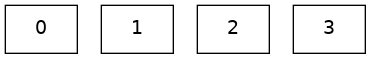

In [35]:
ddf.visualize()

## 7.3. 벙렬로 전처리 수행

n_worker = 4 로 n_thread=4 로 10,000 개시 30초, 20,000 개의 전처리시에 약 45초 걸립니다.

In [36]:
%%time

from IPython.display import display as dp
import traceback
from custom_util import remove_spec_chars

try: 
    # ddf["doc_cl"] = ddf["doc"].apply(preproces_doc, meta=('doc', 'object')).compute()      
    ddf["doc_cl"] = ddf["doc"].apply(remove_spec_chars, meta=('doc', 'object')).compute()      
    ddf["doc_cl"] = ddf["doc_cl"].apply(Okt_tokenizer,meta=('doc_cl', 'object') ).compute()      
    ddf["doc_cl"].compute()
except Exception:
    print(traceback.format_exc())    

distributed.utils_perf - WARNING - full garbage collections took 79% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 68% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 98% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 82% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 96% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 99% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 99% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 99% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 99% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took

CPU times: user 1.54 s, sys: 415 ms, total: 1.95 s
Wall time: 30 s


## 7.4. pandas df 로 변경

das dataframe 에서 pandas dataframe 으로 변경

In [37]:
pd_df = ddf.compute()
pd_df

,doc,doc_cl
0,"그는 ""터키 원전수주 계약은 일본 정부의 장기 위험 보증 조항에 달려 있다""고 덧붙였다.",터키 원전 수주 계약 일본 정부 장기 위험 보증 조항
1,"기재부 고위 관계자는 ""김동연 부총리가 오고 지난해 예산안 통과 과정에서 예산실이 ...",기재부 고위 관계자 김동연 부총리 지난해 예산안 통과 과정 산실 밤샘 근무 하루 예...
2,"선수들을 지도하고 있는 원동현은 ""이번 훈련을 통해 여자핸드볼 국가대표 선수들이 강...",선수 지도 동현 이번 훈련 통해 여자 핸드볼 국가대표 선수 강인하다 해병 정신 무장...
3,"광 작가도 ""게임은 거의 처음 하는 작업인데 새로운 경험이 됐다.",작가 게임 거의 처음 작업 새롭다 경험
4,"김동철 국민의당 원내대표도 강 후보자에 대해 ""도덕적 흠결도 많을뿐더러 그 흠결을 ...",김동철 국민의당 원내대표 후보자 대해 도덕 흠결 많다 흠결 자질 역량 없다 혹평 외...
...,...,...
9995,"현대차 관계자는 ""세계 최초 수소전기차 양산, 워즈오토 10대 엔진 선정, 최고 기...",현대차 관계자 세계 최초 수소 전기차 양산 오토 엔진 선정 최고 기술 탑재 차세대 ...
9996,"그리고 신속하게 결정이 돼야 한다고 말했다""고 밝혔다.",신속하다 결정
9997,"김 회장은 ""직원들에게 공개 구혼을 했으니 답을 기다리고 있다""며 ""직원들의 본심을...",회장 직원 공개 구혼 직원 본심
9998,"당의 한 관계자는 ""당선이 확실하지도 않은 상황에서 장관직과 국회의원까지 던지면서 ...",관계자 당선 확실하다 상황 장관 국회의원 출마


## 7.5. DAS Cluster 셧다운

In [38]:
import time

das_client.shutdown()
time.sleep(5)

distributed.nanny - WARNING - Worker process still alive after 3 seconds, killing
distributed.nanny - WARNING - Worker process still alive after 3 seconds, killing
distributed.nanny - WARNING - Worker process still alive after 3 seconds, killing


## 7.6. (옵션) DAS 에러시에 아래 주석을 제거하고 작업 하세요.
- 10,000 개 실행시에 약 2분 40초 걸림

In [39]:
# %%time
        
# from custom_util import preprocess_doc

# pd_df = preprocess_doc(df)

## 7.7. 전처리 도입 후에 추론

전처리된 Corpus를 embedding encoding 형태로 변경

In [40]:
corpus_cl = pd_df['doc_cl'].tolist()
corpus_embeddings_cl = encode_multi_gpu_embedding(model, corpus_cl)

Batches:   0%|          | 0/157 [00:00<?, ?it/s]

In [41]:
top_k = 5

queries = [' 일록이는 청소년대표 시절부터 단짝 친구고, 신욱이 형은 대표팀에서 훈련할 때 B팀를 꼭 이기고 싶다고 말한 적 있죠. \
           "꼭 이겨야죠.가가와가 도르트문트에 있을 때도 정말 이기고 싶었는데 그러지 못했어요.\
           맨유는 도르트문트보다 좋은 선수가 많은 팀이니 더더욱 꺾고 싶어요.한때는 맨유에 가고 싶다는 생각도 했지만, \
           지금은 소속팀에서 행복하기 때문에 그렇지 않아요." -분데스리가 우승과 득점왕 중 어느 쪽이 더 간절한가요. \
           "우승을 꼭 해보고 싶어요.전 이제껏 우승 트로피를 들어본 적이 한 번도 없거든요.레버쿠젠에서는 충분히 가능한 꿈인 것 같아서 기대돼요." \
           손흥민은 올 시즌 분데스리가, 독일 FA컵, 유럽 챔피언스리그를 합쳐 8경기에 출전해 3골·2도움을 기록 중이다.']
queries = [Okt_tokenizer(queries[0])]
queries
semantic_search(model, corpus, corpus_embeddings_cl, queries, top_k)

Batches:   0%|          | 0/1 [00:00<?, ?it/s]


Query: 청소년 대표 시절 단짝 친구 신욱 대표팀 훈련 팀를 이기 가가 도르트문트 정말 이기 그렇다 맨유 도르트문트 좋다 선수 많다 더욱 맨유 생각 지금 행복하다 때문 그렇다 분데스리가 우승 득점 간절하다 우승 이제껏 우승 트로피 없다 레버쿠젠 충분하다 가능하다 같다 기대 손흥민 시즌 분데스리가 독일 유럽 챔피언스리그 경기 출전 도움 기록 중이

Top 5 most similar sentences in corpus:

(Score: 1.0000) 일록이는 청소년대표 시절부터 단짝 친구고, 신욱이 형은 대표팀에서 훈련할 때 B팀를 꼭 이기고 싶다고 말한 적 있죠. "꼭 이겨야죠.가가와가 도르트문트에 있을 때도 정말 이기고 싶었는데 그러지 못했어요.맨유는 도르트문트보다 좋은 선수가 많은 팀이니 더더욱 꺾고 싶어요.한때는 맨유에 가고 싶다는 생각도 했지만, 지금은 소속팀에서 행복하기 때문에 그렇지 않아요." -분데스리가 우승과 득점왕 중 어느 쪽이 더 간절한가요. "우승을 꼭 해보고 싶어요.전 이제껏 우승 트로피를 들어본 적이 한 번도 없거든요.레버쿠젠에서는 충분히 가능한 꿈인 것 같아서 기대돼요." 손흥민은 올 시즌 분데스리가, 독일 FA컵, 유럽 챔피언스리그를 합쳐 8경기에 출전해 3골·2도움을 기록 중이다.
(Score: 0.4953) 그는 "두리가 골을 넣은 자체는 좋아.그런데 기분이 조금 그래.내 아들이 골을 넣었지만 내 팀이 지니 가슴이 아파"라며 "수원이 빨리 1위를 따라가야 하는데 아들이 수원의 발목을 잡은 거잖아.두리가 넣지 않았어도 서울이 이겼을지도 모르지.내가 정 들었던 내 팀에 그렇게 하니까 마음이 짠했어"라며 안타까움을 전했다.
(Score: 0.4852) 최순호 감독은 선수단을 대표해 "좋은 경기력으로 팬들이 재미있어하는 축구를 선보이겠다"라고 비장한 출사표를 바쳤다.
(Score: 0.4803) 경기 후 손흥민은구단 공식'스퍼스TV'와 인터뷰를 통해 "준결승이 열리는 웸블리 스타디움으로 가는 중요한 경기에서 6-0으로 승리했다"며 "

In [42]:
top_k = 5

queries = ['IBK투자증권 정용택 연구원은 "2008년 12월 이후 누적 기준으로 한국 유가증권시장에서 외국인 누적 순매수 규모를 보면 중국인의 \
            누적 순매수 규모는 올해 1월 기준 6조8000억원으로 전체 외국인 누적 순매수의 11%를 점유했다"며 \
            "한국 경제와 주식시장이 일본보다 상대적으로 중국에 대한 노출도가 높다는 것은 여타 투자자들에게도 \
            중국의 경제보복이 강화될수록 불확실성을 높이며 매도 이유가 될 가능성이 있어 보인다"고 밝혔다.' ]
queries = [Okt_tokenizer(queries[0])]
queries
semantic_search(model, corpus, corpus_embeddings_cl, queries, top_k)

Batches:   0%|          | 0/1 [00:00<?, ?it/s]


Query: 투자 증권 정용택 연구원 이후 누적 기준 한국 유가 증권 시장 외국인 누적 매수 규모 중국인 누적 매수 규모 올해 기준 전체 외국인 누적 수의 점유 한국 경제 주식시장 일본 상대 중국 대한 노출 높다 여타 투자자 중국 보복 강화 불확실 높이 매도 이유 가능성

Top 5 most similar sentences in corpus:

(Score: 1.0000) IBK투자증권 정용택 연구원은 "2008년 12월 이후 누적 기준으로 한국 유가증권시장에서 외국인 누적 순매수 규모를 보면 중국인의 누적 순매수 규모는 올해 1월 기준 6조8000억원으로 전체 외국인 누적 순매수의 11%를 점유했다"며 "한국 경제와 주식시장이 일본보다 상대적으로 중국에 대한 노출도가 높다는 것은 여타 투자자들에게도 중국의 경제보복이 강화될수록 불확실성을 높이며 매도 이유가 될 가능성이 있어 보인다"고 밝혔다.
(Score: 0.6955) 최 차관은 "일본을 비롯한 주요국 증시가 큰 폭으로 하락하는 등 국제 금융시장의 변동성이 확대됐지만 유가 하락, 미국 금리 인상과 관련한 불확실성 확대 등에 주로 기인하는 것으로 평가됐다"고 설명했다.
(Score: 0.6331) 이종우 IBK투자증권 리서치센터장은 "미국, 일본 등 선진국 주식시장이 대세 하락으로 들어가기 시작하면 글로벌 약세 장세로 갈 가능성이 상당히 커서 한국 시장도 방법이 없다"고 말했다.
(Score: 0.5714) 최종구 차관보는 "일본을 제외한 아시아 채권시장에서 한국물이 32%를 차지할 정도로 다른 국가보다 해외 채권 발행규모가 크다"며 "따라서 외국인이 채권을 사면 헤지 수요도 커지기 때문에 CDS 프리미엄이 비교적 높게 상승한 것으로 우려할 수준은 아니다"고 설명했다.
(Score: 0.5554) 간담회에서 왕국강 중국사회과학원 금융연구소장은 "일본 양적완화정책이 자국 경제 회복조치 일환이란 점은 이해한다"면서도 "이는 산업구조가 비슷한 다른 국가들에게 큰 피해를 주기 때문에 선택해서는 안될 길"이라고 지

In [43]:
    
top_k = 5

queries = [ '오뚜기 강구만 홍보실장은 "현재 오뚜기의 국내 카레 시장 점유율은 90%에 이른다"며 \
            "올해 카레의 각종 장점을 알리는 마케팅을 펼쳐 시장을 키우는 한편, 점유율도 좀 더 높이는 게 목표"라고 말했다.']
queries = [Okt_tokenizer(queries[0])]
queries
semantic_search(model, corpus, corpus_embeddings_cl, queries, top_k)

Batches:   0%|          | 0/1 [00:00<?, ?it/s]


Query: 오뚜기 구만 홍보 실장 현재 오뚜기 국내 카레 시장 점유 올해 카레 각종 장점 마케팅 시장 한편 점유 율도 목표

Top 5 most similar sentences in corpus:

(Score: 1.0000) 오뚜기 강구만 홍보실장은 "현재 오뚜기의 국내 카레 시장 점유율은 90%에 이른다"며 "올해 카레의 각종 장점을 알리는 마케팅을 펼쳐 시장을 키우는 한편, 점유율도 좀 더 높이는 게 목표"라고 말했다.
(Score: 0.6165) 오뚜기 관계자는 "지난 4월말부터 최근 가장 핫한 먹방 개그맨인 김준현씨를 광고모델로 기용한 오뚜기 컵밥과 함흥비빔면 TV 광고를 진행하고 있다"며 "콩국수라면, 함흥비빔면, 컵밥이 올해 여름 식품시장에서 큰 역할을 할 수 있을 것으로 기대한다"고 말했다.
(Score: 0.5205) 또한 박태환 선수가 메달을 딸 때마다 후속 편을 준비했는데 그 광고에는 대화형식으로 "오빠 달려" 라고 외치는 귀여운 김연아와, "물속이거든" 이라고 대답하는 시크한 박태환이 등장한다.
(Score: 0.5009) 위험에 처한 타조가 숨기 위해 덤불 속에 머리만 처박고 안 보일 것이라 생각하는 모습을 비유한 것"이라며 "이같은 문재인 정부의 안보불감증 때문에 일촉즉발의 위기 상황에도 강대국들은 코리아 패싱을 하고 있는 것"이라고 주장했다.
(Score: 0.4555) 제페토 포인트 블랭크 스튜디오의 김건우 본부장은 "25개 국가가 함께 플레이 하는 것을 장점으로 활용, 국가간 경쟁을 통해 게임을 즐길 수 있도록 UI에 국가 마크를 표시하는 등의 시도가 성공적이었다.


# 7. Semantic Search (상품 리뷰)



In [44]:
product_best_data_file = 'data/product_review/best_sample.json'

In [45]:
import json

with open(product_best_data_file) as json_file:
    best_review_data = json.load(json_file)
    
best_df = pd.DataFrame(best_review_data)
best_df.rename(columns={'contents' : 'doc'}, inplace=True)
best_df

FileNotFoundError: [Errno 2] No such file or directory: 'data/product_review/best_sample.json'

In [ ]:
%%time
pd.set_option('max_colwidth', 1000)

from custom_util import preprocess_doc

best_df_cl = preprocess_doc(best_df)
best_df_cl

In [ ]:
corpus_cl = best_df_cl['doc_cl'].tolist()
corpus = best_df_cl['doc'].tolist()
corpus_pd_review_embeddings_cl = encode_multi_gpu_embedding(model, corpus_cl)

In [ ]:
    
top_k = 5

queries = [ '매콤어묵도 깔끔한 맛이에요']
queries = [Okt_tokenizer(queries[0])]
queries
semantic_search(model, corpus, corpus_pd_review_embeddings_cl, queries, top_k)

In [ ]:
    
top_k = 5

queries = [ '한개가 간장소스가 다 터져서 문의글 남기면서 보니, \
            간장 터져서 왔다는 글이 많이 보이네요. 맛있는데 불안해서 또 시킬 수 있을지 모르겠네요ㅜㅜ'
          ]
queries = [Okt_tokenizer(queries[0])]
queries
semantic_search(model, corpus, corpus_pd_review_embeddings_cl, queries, top_k)

In [ ]:
    
top_k = 5

queries = [ '가격 : 할인가 개당 3,720원 (2개 이상 구입 필수) 양 : 1인분으로 평범한 양, \
            점심에 먹는 것을 추천 조리시간 및 난이도 : 약 7분, 라면 끓이는 수준의 난이도 평가 : 시중에 파는 \
            우동이 2천원대라는 점을 비교하면 3천원대로 나름 고급형 우동을 집에서 편하게 먹을 수 있어요. \
            어묵 사이즈는 여성 손바닥 정도이고, 한장 크게 들어가있어서 먹으면서 잘라 먹거나 베어 먹으면 됩니다. \
            국물과 어묵이 맛있어서 우동면 하나도 남기지 않고 다 먹었어요. \
            고추우동이라서 살짝 매콤한가 했는데 전혀 맵지 않고 칼칼함도 없이 시원하고 짭쫄한 맛입니다. \
            조리 방법은 뒷면에 상세하게 나와있어서 라면 끓일 줄 아는 분들이면 쉽게 따라할 수 있을거에요. \
            저는 설명서에 다른 채소와 함께 끓이면 더 맛있다고 하여 알배기배추 작은 거 추가해줬더니 씹는 맛이 일품이네요. \
            냉장고에 남는 채소 있으면 같이 끓이시는 것 추천! 맛있게 잘 먹었습니다 :)'
          ]
queries = [Okt_tokenizer(queries[0])]
queries
semantic_search(model, corpus, corpus_pd_review_embeddings_cl, queries, top_k)

distributed.client - ERROR - Failed to reconnect to scheduler after 30.00 seconds, closing client


2022-08-11 14:22:34 - _GatheringFuture exception was never retrieved
future: <_GatheringFuture finished exception=CancelledError()>
asyncio.exceptions.CancelledError
